In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import integrate
from tqdm import tqdm
import matplotlib.animation as anim
from mpl_toolkits.mplot3d import axes3d

# Punto 1

In [2]:
#Construcción de Sistema y Función Solución

def numsolfunc(t, q):

    def System (t, r0):

        u = r0
        u_dot = u**q
        
        return(np.array([u_dot]))

    solution = solve_ivp(System, (t[0], t[-1]), r0, t_eval = t, method = "RK45")

    return solution.y[0]



def ansolfunc(t, q):
    if q == 1:
        return(np.exp(t))
    elif q < 1:
        return (t*(1-q)+1)**(1/(1-q))

In [3]:
#Discretización 

N = 6
t = np.linspace(0,10,N)

r0 = np.array([1])
q = np.array([0., 0.2, 0.4, 0.7, 0.9, 1 ])

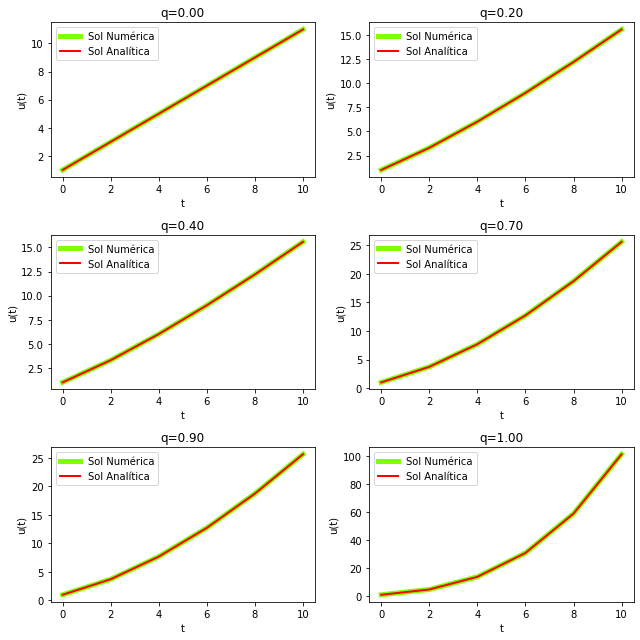

In [4]:
fig, axs = plt.subplots(3,2,figsize=(9,9))

position = 0

for n in range (3):
    for m in range(2):
        axs[n][m].plot(t,numsolfunc(t,q[n+m]), linewidth = 5, color = "chartreuse", label = "Sol Numérica")
        axs[n][m].plot(t,ansolfunc(t,q[n+m]), linewidth = 2, color = "r", label = "Sol Analítica")
        axs[n][m].set_xlabel("t")
        axs[n][m].set_ylabel("u(t)")
        axs[n][m].set_title("q={:.2f}".format(q[position]))

        position += 1

        axs[n][m].legend()

fig.tight_layout()



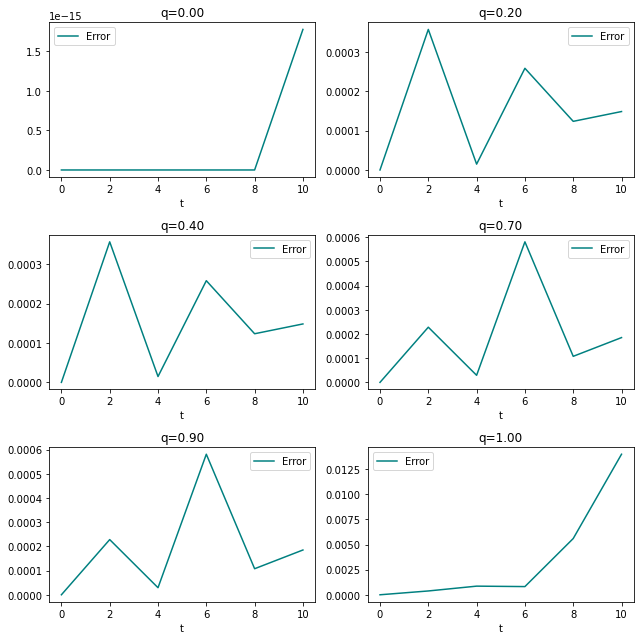

In [5]:
fig, axs = plt.subplots(3,2,figsize=(9,9))

position = 0

for n in range (3):
    for m in range(2):

        un = numsolfunc(t,q[n+m])
        u_exact = ansolfunc(t,q[n+m])


        axs[n][m].plot(t,np.abs(u_exact-un), color = "teal", label = "Error")
        axs[n][m].set_xlabel("t")
        axs[n][m].set_title("q={:.2f}".format(q[position]))

        position += 1

        axs[n][m].legend()

fig.tight_layout()

# Punto 3

In [6]:
class Particle():
    
    def __init__(self, r0,v0,a0,t,m,radius,Id):
        
        self.dt = t[1]-t[0]
        
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.rVector = np.zeros((len(t),len(r0)))
        self.vVector = np.zeros((len(t),len(v0)))
        self.aVector = np.zeros((len(t),len(a0)))
        
        self.L = np.zeros(len(r0))
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        self.MomentumVector = np.zeros((len(t),len(v0)))
        self.AngularMomentumVector = np.zeros((len(t),len(v0)))
        
        self.EpVector = np.zeros((len(t),1))
        self.EkVector = np.zeros((len(t),1))
        
        
        self.Ep = 0.
        self.Force = self.m * self.a
        self.G = 4*np.pi**2
        self.epsi = 0.1
        
        # Initial condition
        
        # Esto significa en el pasado
        
        self.rp = r0
        self.vp = v0
        
           
        
    def Evolution(self,i):
        
        # fill vectors
        
        self.SetPosition(i,self.r)
        self.SetVelocity(i,self.v)
        self.SetMomentum(i,self.m*self.v)
        
        
        # Energy 
        
        self.SetEk(i,self.GetKineticEnergy())
        self.SetEp(i,self.GetPotentialEnergy())
        
        # Change variables using the verlet method
        
        self.a = self.Force/self.m
        
     
        if i == 0:
            
            self.rp = self.r
            self.r = self.rp + self.dt * self.v
        
        else:
            
            self.rf = 2*self.r - self.rp + self.a * self.dt**2            
            self.v = ( self.rf - self.rp ) / (2*self.dt)
            
            self.rp = self.r
            self.r = self.rf
        
  
            
    def ResetForce(self):
        
        self.Force[:] = 0.
        self.a[:] = 0.
        self.Ep = 0.
        
    
    
    # Setters
    
    def SetPosition(self,i,r):
        self.rVector[i] = r
        
    def SetVelocity(self,i,v):
        self.vVector[i] = v   
        
    def SetMomentum(self,i,p):
        self.MomentumVector[i] = p
        
    def SetAngularMomentum(self,i,r,p):
        
    
        self.L[0] = r[1]*p[2] - r[2]*p[1]
        self.L[1] = -(r[0]*p[2] - r[2]*p[0])
        self.L[2] = r[0]*p[1] - r[1]*p[0]
        
        self.AngularMomentumVector[i] = self.L
            
    def SetEk(self,i,Ek):
        self.EkVector[i] = Ek
    
    def SetEp(self,i,Ep):
        self.EpVector[i] = Ep

    
    # Getters
    
    def GetForce(self,p):
        
        d = np.linalg.norm( self.r - p.GetPosition() )
        
        Fn = - self.G * self.m * p.m / (d**2+self.epsi**2)**(3/2)
        
        self.Force = np.add( self.Force, Fn* (self.r - p.GetPosition())  )
        
        self.Ep += - self.G * self.m * p.m / (d**2+self.epsi**2)**(0.5)
                
    
    def GetPosition(self):
        return self.r
    
    def GetPositionVector(self):
        return self.rVector
    
    def GetReducePosition(self):
        return self.RrVector
        
    def GetVelocityVector(self):
        return self.vVector    
    
    def GetMomentumVector(self):
        return self.MomentumVector
    
    def GetAngularMomentumVector(self):
        return self.AngularMomentumVector
        
    def GetReduceVelocity(self):
        return self.RvVector
     
    def GetKineticEnergy(self):
        return 0.5*self.m*np.linalg.norm(self.v)**2
    
    def GetPotentialEnergy(self):
        #return -np.dot( self.m*self.a, self.r )
        return 0.5*self.Ep 
   
    def GetNetForce(self):
        return self.Force

    def GetR(self):
        return self.radius
  
    # Reducing size

    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]])
        
        for i in range(1,len(self.rVector)):
            if i%factor == 0:
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                
        self.RvVector = np.array([self.vVector[0]])
        
        for i in range(1,len(self.vVector)):
            if i%factor == 0:
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])

In [7]:
def GetParticles(NParticles,Limit,Velo,Dim=3,dt=0.001):
    
    Particles_ = []
    G = 4*np.pi**2

    
    for i in range(NParticles):
        
        theta = np.random.uniform(0, 2 * np.pi, NParticles)
        a = np.random.uniform(-1, 1, NParticles)
        phi = np.arccos(a)

        #Obtiene las coordenadas cartesianas de los puntos del cascarón

        x_on = np.cos(theta)*np.sin(phi)
        y_on = np.sin(theta)*np.sin(phi)
        z_on = np.cos(phi)
        
        r0 = np.array([x_on[i], y_on[i], z_on[i]])
        v0 = np.array([0.,0.,0.])
        a0 = np.array([0.,0.,0.])
        
        p = Particle(r0,v0,a0,t,m,0.3,i)
        
        Particles_.append(p)
        
        
    return Particles_

In [8]:
Limits = np.array([10.,10.,10.]) 

In [9]:
Particles = GetParticles(1,Limits[0],Velo = 0,dt=0.001)
Particles[0]

In [10]:
def RunSimulation(t,NParticles = 100, Velo = 0):
    
    # Creating the particles
    Particles = GetParticles(NParticles,Limits[0],Velo = Velo,dt=dt)
      
    for it in tqdm(range(len(t))):
        
        NetForce = np.array([0,0,0])
        
        for i in range(len(Particles)):    
            for j in range(len(Particles)):
                if i != j:
                    Particles[i].GetForce(Particles[j])
             
        #    NetForce = np.add(NetForce,Particles[i].GetNetForce())
            
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            
            #Particles[i].CheckWallLimits(Limits)
             
        #print(NetForce)
        
    return Particles

In [11]:
dt = 0.001
tmax = 2.
t = np.arange(0.,tmax+dt,dt)

In [12]:
Particles = RunSimulation(t,10,Velo = 0)

100%|█████████████████████████████████████████████████████████████████████████████| 2001/2001 [00:04<00:00, 485.80it/s]


In [13]:
EnergiaK = Particles[0].EkVector
EnergiaP = Particles[0].EpVector
EnergiaTotal = Particles[0].EkVector + Particles[0].EpVector

for i in range(1,len(Particles)):
    EnergiaK = np.add(EnergiaK, Particles[i].EkVector)
    EnergiaP = np.add(EnergiaP, Particles[i].EpVector)
    EnergiaTotal = np.add(EnergiaTotal, Particles[i].EkVector + Particles[i].EpVector) 

Momentum = Particles[0].GetMomentumVector()
for i in range(1,len(Particles)):
    Momentum = np.add(Momentum, Particles[i].GetMomentumVector()) 

AngularMomentum = Particles[0].GetAngularMomentumVector()
for i in range(1,len(Particles)):
    AngularMomentum = np.add(AngularMomentum, Particles[i].GetAngularMomentumVector()) 

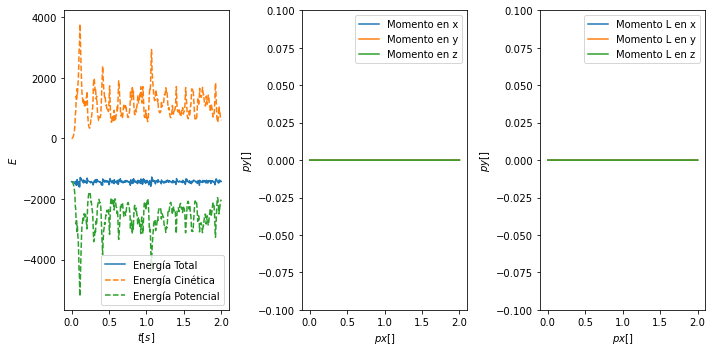

In [14]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(1,3,1)
ax2 = fig1.add_subplot(1,3,2)
ax3 = fig1.add_subplot(1,3,3)

ax1.plot(t,EnergiaTotal, label='Energía Total')
ax1.plot(t,EnergiaK,'--',label='Energía Cinética')
ax1.plot(t,EnergiaP,'--',label='Energía Potencial')
ax1.set_xlabel(r'$t[s]$',fontsize=10)
ax1.set_ylabel(r'$E$',fontsize=10)
#ax1.set_yscale('log')
ax1.legend(loc=0)


ax2.plot(t,Momentum[:,0], label='Momento en x')
ax2.plot(t,Momentum[:,1], label='Momento en y')
ax2.plot(t,Momentum[:,2], label='Momento en z')
ax2.set_xlabel(r'$px[]$',fontsize=10)
ax2.set_ylabel(r'$py[]$',fontsize=10)
ax2.legend(loc=0)
ax2.set_ylim(-0.1,0.1)


ax3.plot(t,AngularMomentum[:,0], label='Momento L en x')
ax3.plot(t,AngularMomentum[:,1], label='Momento L en y')
ax3.plot(t,AngularMomentum[:,2], label='Momento L en z')
ax3.set_xlabel(r'$px[]$',fontsize=10)
ax3.set_ylabel(r'$py[]$',fontsize=10)
ax3.legend(loc=0)
ax3.set_ylim(-0.1,0.1)


fig1.tight_layout()

plt.show()

#plt.savefig('NBodyEnergia.pdf')

In [15]:
def ReduceTime(t,factor):
    
    for p in Particles:
        p.ReduceSize(factor)
    
    Newt = []
    for i in range(len(t)):
        if i%factor == 0:
            Newt.append(t[i])
            
    return np.array(Newt)

In [16]:
redt = ReduceTime(t,100)

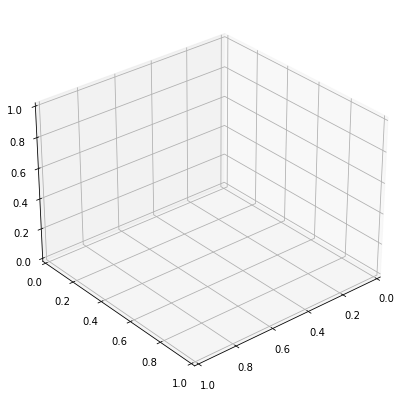

In [48]:
fig2 = plt.figure(figsize=(7,7))
ax = fig2.add_subplot(1,1,1, projection = '3d',elev = 30, azim = 50)
    
def init():
    ax.set_xlabel(r'$x[m]$',fontsize=15)
    ax.set_ylabel(r'$y[m]$',fontsize=15)
    ax.set_zlabel(r'$z[m]$',fontsize=15)
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    ax.set_zlim(-2,2)


def Update(i):
    
    plot = ax.clear()
    init()
    
    for p in Particles:
        
        x = p.GetReducePosition()[i,0]
        y = p.GetReducePosition()[i,1]
        z = p.GetReducePosition()[i,2]
        
        #ax.set_title(r'$t=%.2f \ years$' %(redt[i]))
        
        ax.scatter(x,y,z,marker='.', size = 30)
   
    plot = ax.legend()
            
    return plot
    
Animation = anim.FuncAnimation(fig2,Update,frames=len(redt),init_func=init)

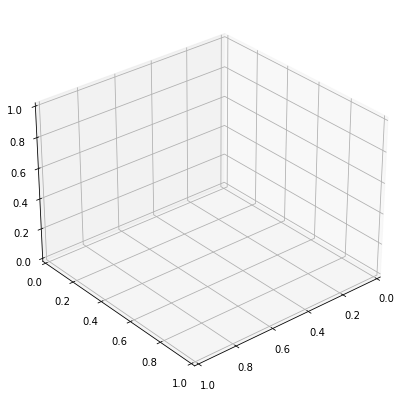

In [42]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1, projection = '3d',elev = 30, azim = 50)
    
def init():
    ax.set_xlabel(r'$x[m]$',fontsize=15)
    ax.set_ylabel(r'$y[m]$',fontsize=15)
    ax.set_zlabel(r'$z[m]$',fontsize=15)
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    ax.set_zlim(-2,2)


def Update(i):
    
    for p in Particles:
        
        x = p.GetReducePosition()[i,0]
        y = p.GetReducePosition()[i,1]
        z = p.GetReducePosition()[i,2]
        
        plot = ax.set_title(r'$t=%.2f \ years$' %(redt[i]))
        
        plot = ax.scatter(x,y,z,marker='.')
        
     
   
    plot = ax.legend()
            
    
Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)

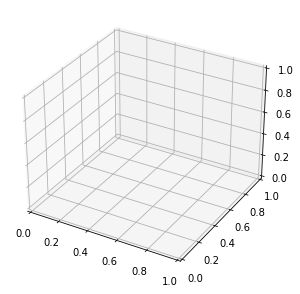

In [52]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection = '3d')


def init():
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    ax.set_zlim(-2,2)
    ax.set_xlabel(r'$x[m]$',fontsize=15)
    ax.set_ylabel(r'$y[m]$',fontsize=15)
    ax.set_zlabel(r'$z[m]$',fontsize=15)
def Update(i):
    
    plot = ax.clear()
    init()
    plot = ax.set_title(r'$t=%.2f \ years$' %(redt[i]), fontsize=15)
    
    for p in Particles:
        x = p.GetReducePositionVector()[i,0]
        y = p.GetReducePositionVector()[i,1]
        z = p.GetReducePositionVector()[i,2]
        vx = p.GetVelocityVector()[i,0]
        vy = p.GetVelocityVector()[i,1]
        vz = p.GetVelocityVector()[i,2]
        plot = ax.scatter(x,y,z,marker='.',color="black")
        
        #plot = ax.arrow(x,y,vx,vy,color='r',head_width=0.5)
        
    return plot

Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)